In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt

from scipy.special import entr # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html
from keras.utils import to_categorical
import keras.metrics as metrics
from kf_impl import EKF_CV_MODEL
from lstm_impl import CombinedLSTM
import pdb

Using TensorFlow backend.


### Data Loading

In [2]:
# The function to extract training data from pickles
def extract_data(pklfile, crop=None):
    with open(pklfile, 'rb') as f:
        dataset_all = pickle.load(f)
        
    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    history_traj_data = np.array(dataset_all['features'])[:, :, :]

    # All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    future_traj_data = np.array(dataset_all['labels'])[:, :, :-1]

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if crop is not None:
        raise NotImplementedError("TODO")
    
    return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
def build_train_test_splits(pklfiles_to_process, num_pkl_folds=5):
    # Using a suboptimal approach here:
    # Just build a list of dictionaries, where entry_i 
    # corresponds to train split i.

    train_sets = []
    test_sets  = []
    
    
    inds = np.arange(num_pkl_folds)
    
    for hold_out_ind in inds:
        train_inds = np.delete(inds, hold_out_ind)
        
        train_set = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}

        test_set  = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}
        
        # Train Set
        for fold in train_inds:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if train_set['history_traj_data'] is None:
                train_set['history_traj_data'] = history_traj_data
                train_set['future_traj_data']  = future_traj_data
                train_set['goal_position']     = goals_position
                train_set['one_hot_goal']      = one_hot_goal         
            else:
                train_set['history_traj_data'] = np.append(train_set['history_traj_data'], history_traj_data, axis=0)
                train_set['future_traj_data']  = np.append(train_set['future_traj_data'], future_traj_data, axis=0)
                train_set['goal_position']     = np.append(train_set['goal_position'], goals_position, axis=0)
                train_set['one_hot_goal']      = np.append(train_set['one_hot_goal'], one_hot_goal, axis=0)

        # Test Set
        for fold in [hold_out_ind]:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if test_set['history_traj_data'] is None:
                test_set['history_traj_data'] = history_traj_data
                test_set['future_traj_data']  = future_traj_data
                test_set['goal_position']     = goals_position
                test_set['one_hot_goal']      = one_hot_goal         
            else:
                test_set['history_traj_data'] = np.append(test_set['history_traj_data'], history_traj_data, axis=0)
                test_set['future_traj_data']  = np.append(test_set['future_traj_data'], future_traj_data, axis=0)
                test_set['goal_position']     = np.append(test_set['goal_position'], goals_position, axis=0)
                test_set['one_hot_goal']      = np.append(test_set['one_hot_goal'], one_hot_goal, axis=0)
                
        train_sets.append(train_set)
        test_sets.append(test_set)
        
    return train_sets, test_sets

In [4]:
# Metric Definitions

def dist_by_timestep(traj_pred, traj_actual):
    # returns avg, min, max distance error across each timestep
    diff = traj_pred - traj_actual # N by N_pred by 2
    diff_xy_norm = np.linalg.norm(diff, axis=2)
    return np.mean(diff_xy_norm, axis=0), np.min(diff_xy_norm, axis = 0), np.max(diff_xy_norm, axis=0)

def top_k_accuracy(goal_pred, goal_actual, k=1):
    # returns empirical probability of the real goal being contained
    # in the top k most likely goal set from goal_pred.
    return np.mean(metrics.top_k_categorical_accuracy(goal_actual, goal_pred, k=k))

def mean_entropy(goal_pred):
    # returns the avg. entropy of the goal prediction dist.
    # higher entropy indicates more uncertain predictions
    N = goal_pred.shape[0]
    
    entr_matrix = entr(goal_pred)
    entr_by_instance = np.sum(entr_matrix, axis=1) #entropy by snippet
    return np.mean(entr_by_instance)

In [5]:
# Construct the evaluation datasets.
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
train_sets, test_sets = build_train_test_splits(pklfiles_to_process, num_pkl_folds=5)

# Build the model bank.
models = [EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)]
names =  ['EKF_CV']

# Build Trajectory Model
# history_shape = train_sets[0]['history_traj_data'].shape
# goal_position_shape = train_sets[0]['goal_position'].shape
# one_hot_goal_shape = train_sets[0]['one_hot_goal'].shape
# future_shape = train_sets[0]['future_traj_data'].shape
# Hard coded for now, need to make this more robust:
history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)

for hidden_dim in [100]:
    for beta in [0.001]:
        models.append(
            CombinedLSTM(history_shape,
                         goal_position_shape,
                         one_hot_goal_shape,
                         future_shape,
                         hidden_dim,
                         beta=beta)
        )
    
        names.append('LSTM_h%d_b%.3f' % (hidden_dim, beta))
            
metric_dicts = [] # same indexing/length as names/models

for name, model in zip(names, models):
    metric_dict = {}
    metric_dict['traj_dist_vs_N'] = [] # k by N_pred matrix
    metric_dict['goal_top_1_acc'] = [] # k-vector
    metric_dict['goal_top_3_acc'] = [] # k-vector
    metric_dict['goal_top_5_acc'] = [] # k-vector
    metric_dict['goal_entropy']   = [] # k-vector
    
    for i_fold, (train_set, test_set) in enumerate(zip(train_sets, test_sets)):
        print('Training %s, Fold %d' % (name, i_fold))
        model.fit(train_set, test_set)
        goal_pred, traj_pred = model.predict(test_set)
        
        meand, mind, maxd = dist_by_timestep(traj_pred, test_set['future_traj_data'][:,:,:2])
        
        t1 = top_k_accuracy(goal_pred, test_set['one_hot_goal'], k=1)
        t3 = top_k_accuracy(goal_pred, test_set['one_hot_goal'], k=3)
        t5 = top_k_accuracy(goal_pred, test_set['one_hot_goal'], k=5)

        ment = mean_entropy(goal_pred)
        
        # TODO: test vs. train, not just test?
        metric_dict['traj_dist_vs_N'].append(meand)
        metric_dict['goal_top_1_acc'].append(t1)
        metric_dict['goal_top_3_acc'].append(t3)
        metric_dict['goal_top_5_acc'].append(t5)
        metric_dict['goal_entropy'].append(ment)
    
    metric_dicts.append(metric_dict)

Training EKF_CV, Fold 0
Training EKF_CV, Fold 1
Training EKF_CV, Fold 2
Training EKF_CV, Fold 3
Training EKF_CV, Fold 4
Training LSTM_h100_b0.001, Fold 0
Training LSTM_h100_b0.001, Fold 1
Training LSTM_h100_b0.001, Fold 2
Training LSTM_h100_b0.001, Fold 3
Training LSTM_h100_b0.001, Fold 4


In [6]:
# TODO: port Xu's visualization code.
print(len(metric_dicts))

2


Model:  EKF_CV
	Top 1: 
		Mean:  0.5093516
		Std:  0.017104732
		Min:  0.48725212
		Min:  0.53824365
	Top 3: 
		Mean:  0.84231913
		Std:  0.020482363
		Min:  0.8181818
		Min:  0.875
	Top 5: 
		Mean:  0.96256435
		Std:  0.007899023
		Min:  0.95184135
		Min:  0.97159094
	Entropy: 
		Mean:  1.59153759499597
		Std:  0.02139294878303354
		Min:  1.5559388844737632
		Min:  1.6230801061440445
Model:  LSTM_h100_b0.001
	Top 1: 
		Mean:  0.8712047
		Std:  0.02851938
		Min:  0.83522725
		Min:  0.9093484
	Top 3: 
		Mean:  0.9920599
		Std:  0.0021177942
		Min:  0.98866856
		Min:  0.9943343
	Top 5: 
		Mean:  0.99829704
		Std:  0.001390458
		Min:  0.99715906
		Min:  1.0
	Entropy: 
		Mean:  0.28223076
		Std:  0.036763158
		Min:  0.25454834
		Min:  0.35416883


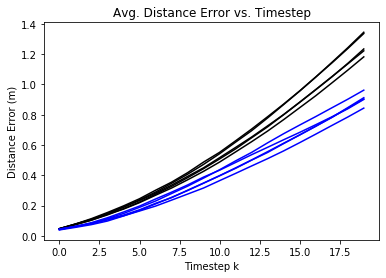

In [7]:
for name, mdict in zip(names, metric_dicts):
    print('Model: ', name)
    print('\tTop 1: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_1_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_1_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_1_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_1_acc']))
    
    print('\tTop 3: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_3_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_3_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_3_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_3_acc']))
    
    print('\tTop 5: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_5_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_5_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_5_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_5_acc']))
    
    print('\tEntropy: ')
    print('\t\tMean: ', np.mean(mdict['goal_entropy']))
    print('\t\tStd: ' , np.std(mdict['goal_entropy']))
    print('\t\tMin: ' , np.min(mdict['goal_entropy']))
    print('\t\tMin: ' , np.max(mdict['goal_entropy']))
    
    N_pred = 20 # hard coded for now
    
    for i_fold in range(len(test_sets)):
        if 'EKF' in name:
            plt.plot(np.arange(N_pred), mdict['traj_dist_vs_N'][i_fold], 'k')
        else:
            plt.plot(np.arange(N_pred), mdict['traj_dist_vs_N'][i_fold], 'b')

plt.title('Avg. Distance Error vs. Timestep')
plt.xlabel('Timestep k')
plt.ylabel('Distance Error (m)')
plt.show()